# Module 3 Final Project Submission

- Student Name: John Dean
- Student Pace: Part Time
- Scheduled Review: 9/11/2020 14:00
- Instructor Name: Eli Thomas
- Blog Post URL: 

# Summary

# Introduction

Since their introduction in the late 1950's, credit cards have always been subject to fraud. For the first few decades, however, the problem was generally manageable. This changed rapidly with the rise of online shopping. Traditional fraud protections such as microchips or holograms on cards have no impact when a purchase is happening online, and the amount of online transactions has increased exponentially in the last decade. 

This created a need for a more modern approach to tackling credit fraud. In 2016, more than 39 million credit card payments occurred *each day*. With such a large flood of transactions, it's imperative for creditors to take advantage of strong predictive models to reduce their liability for credit fraud. To this end, we will evaluate several different algorithms for classifying credit fraud.

We will begin with a simple logistic regression model. Because of the size of the dataset and its extreme imbalance, we expect that this model will be subpar. We will use this to show the drastic difference between traditional regression and the newer algorithms we will try. Following logistic regression, we will use the a Support Vector Machine-Based model (SVM), and finally we will use an Isolation Forest Anomaly detection algorithm.

# Conclusions

# Preprocessing

### Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import zipfile
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix,roc_curve 
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import RFE

import warnings

In [2]:
zf = zipfile.ZipFile('data.zip')
cc_df = pd.read_csv(zf.open('creditcard.csv'))
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis

In [3]:
cc_df.shape

(284807, 31)

In [4]:
cc_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The features in this data set have likely been transformed using PCA dimensionality reduction in order to protect consumer identities and information, thus we have most features listed in the generic Vx form. The normalization of feature values should actually help make our algorithms more effective, so while we may lose some context, we will gain some accuracy.

In [6]:
cc_df.isna().values.any()

False

No missing values. This is great news and we can continue with our analysis. Next we will check to see how balanced our data is.

In [7]:
cc_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
Fraud = cc_df[cc_df['Class']==1]
Valid = cc_df[cc_df['Class']==0]
state = np.random.RandomState(77)
outlier_fraction = len(Fraud)/float(len(Valid))
outlier_fraction

0.0017304750013189597

Only 492 cases of fraud out of nearly 285000 transactions! This is an extremely unbalanced data set. As we mentioned before, this will cause us problems in our first classification model, and we will discuss how to address that later. Let's move on and look for any sources of multicollinearity.

In [9]:
correlation_matrix = cc_df.corr().round(2)

<AxesSubplot:>

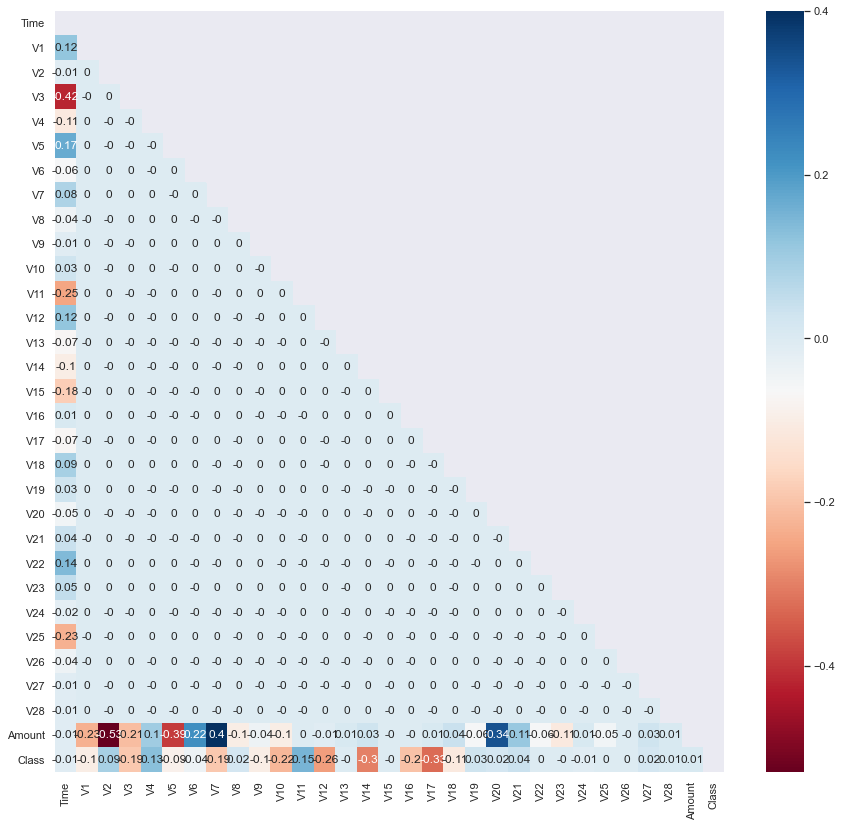

In [10]:
sns.set(rc={'figure.figsize':(15,14)})
mask = np.zeros_like(correlation_matrix,dtype=np.bool)

# Create a msk to draw only lower diagonal corr map
mask[np.triu_indices_from(mask)] = True
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, cmap='RdBu', annot=True, mask=mask)

There does not appear to be any worry about multicollinearity amongst our features. With that determined, we can feel safe moving on.

# Prediction Models

## Functions

In [32]:
def perform_evaluate(title,cm,X,y):
    print(title)
    y_pred = cm.predict(X)
    print("accuracy: {}".format(accuracy_score(y,y_pred)))
    print("precision: {}".format(precision_score(y,y_pred)))
    print("recall: {}".format(recall_score(y,y_pred)))
    print("f1: {}".format(f1_score(y,y_pred,average='binary')))
    print(" ")

def grid_search(cm, param_grid, X_train,y_train,X_test, y_test ):
    rf_grid_search = GridSearchCV(cm, param_grid, cv=3,
                              return_train_score=True)
    rf_grid_search.fit(X_train, y_train)

    rf_grid_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
    rf_grid_score = rf_grid_search.score(X_test, y_test)
    rf_grid_search.best_params_
    print(f"Mean Training Score: {rf_grid_training_score :.2%}")
    print(f"Mean Test Score: {rf_grid_score :.2%}")
    print(f"Best Parameter Combination Found During Grid Search: {rf_grid_search.best_params_ :}")
    
    
def randomized_search(cm, param_random, X_train,y_train,X_test, y_test ):
    rf_grid_search = GridSearchCV(cm, param_random, cv=3,
                              return_train_score=True)
    rf_grid_search.fit(X_train, y_train)

    rf_grid_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
    rf_grid_score = rf_grid_search.score(X_test, y_test)
    rf_grid_search.best_params_
    print(f"Mean Training Score: {rf_grid_training_score :.2%}")
    print(f"Mean Test Score: {rf_grid_score :.2%}")
    print(f"Best Parameter Combination Found During Grid Search: {rf_grid_search.best_params_ :}")
        


def plot_conf_matrix(cm,X_train, y_train,X_test, y_test,class_names):
        fig, axes = plt.subplots(1,2, figsize = (10,6), sharey = 'row')
        plot_confusion_matrix(estimator = cm, X=X_train, y_true=y_train,
                              display_labels=class_names,
                              cmap=plt.cm.Blues, ax=axes[0])
        axes[0].set_title("Training Set Confusion Matrix")
        
        plot_confusion_matrix(estimator = cm, X=X_test, y_true=y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues, ax=axes[1])
        axes[1].set_title("Testing Set Confusion Matrix")
        plt.grid(False)
        plt.show() 
    
def plot_roc(cm,X_train, y_train,X_test, y_test):
    fig, axes = plt.subplots(1,2, figsize = (10,6), sharey = 'row')
    y_pred_train = cm.predict(X_train)
    plot_roc_curve(cm, X_train, y_train, ax=axes[0])
    axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[0].set_title("ROC Curve for Traning")
    
    
    y_pred_test = cm.predict(X_test)
    plot_roc_curve(cm, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[1].set_title("ROC Curve for Testing")
    
    plt.show() 
    
   
    
class_names = ["Normal","Fraud"]

def Mean_Trainin_Testing_score(cm,X_train, y_train,X_test, y_test):
    cm.fit(X_train, y_train)

    cm_training_score = cm.score(X_train, y_train)
    cm_test_score = cm.score(X_test, y_test)
    print(f"Mean Training Score: {cm_training_score :.2%}")
    print(f"Mean Test Score: {cm_test_score :.2%}")

## Logistic Regression

Our first model will be a logistic regression, which we believe will be the least effective model due to the imbalances in the data.

In [12]:
cc_df_x = cc_df.drop(columns=['Class'], axis = 1)
cc_df_y = cc_df['Class']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(cc_df_x, cc_df_y, test_size = 0.25, random_state=state)

In [14]:
logreg = LogisticRegression(random_state = state, solver ='lbfgs',  n_jobs=-1)

In [15]:
logreg.fit(x_train, y_train)

LogisticRegression(n_jobs=-1,
                   random_state=RandomState(MT19937) at 0x14235686990)

In [16]:
lr_predictions = logreg.predict(x_test)

In [17]:
print("accuracy: {}".format(accuracy_score(y_test,lr_predictions)))
print("precision: {}".format(precision_score(y_test,lr_predictions)))
print("recall: {}".format(recall_score(y_test,lr_predictions)))
print("f1: {}".format(f1_score(y_test,lr_predictions,average='binary')))
print(" ")

accuracy: 0.9988623915058565
precision: 0.6779661016949152
recall: 0.6504065040650406
f1: 0.6639004149377593
 


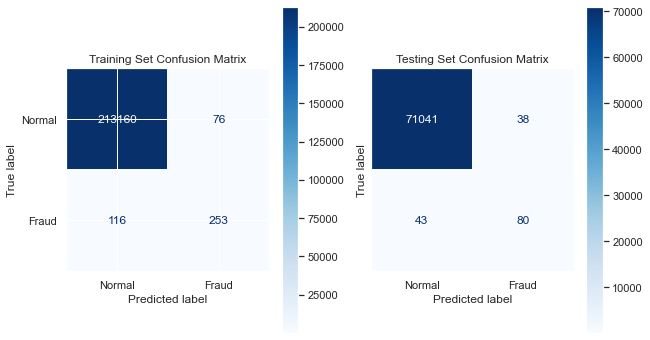

In [33]:
plot_conf_matrix(logreg, x_train, y_train, x_test, y_test, class_names)

## Support Vector Machine-based Classification

In [61]:
svm_reg = OneClassSVM(gamma=0.1,nu=0.05)

In [62]:
svm_reg.fit(x_train)
svm_predictions = svm_reg.predict(x_test)
svm_predictions[svm_predictions == 1] = 0
svm_predictions[svm_predictions == -1] = 1

In [65]:
print("accuracy: {}".format(accuracy_score(y_test,svm_predictions)))
print("precision: {}".format(precision_score(y_test,svm_predictions)))
print("recall: {}".format(recall_score(y_test,svm_predictions)))
print("f1: {}".format(f1_score(y_test,svm_predictions,average='binary')))
print(" ")

accuracy: 0.008342462290385102
precision: 0.0016403410778172151
recall: 0.943089430894309
f1: 0.003274985883681536
 


## Isolation Forest Anomaly Detection 

In [37]:
cc_isof = IsolationForest(max_samples=len(x_train), 
                          contamination=outlier_fraction, 
                          random_state=state, 
                          n_jobs = -1)

In [42]:
cc_isof.fit(x_train)
scores_predictions = cc_isof.decision_function(x_train)
isof_predictions = cc_isof.predict(x_test)

In [43]:
isof_predictions[isof_predictions == 1] = 0
isof_predictions[isof_predictions == -1] = 1
print("accuracy: {}".format(accuracy_score(y_test,isof_predictions)))
print("precision: {}".format(precision_score(y_test,isof_predictions)))
print("recall: {}".format(recall_score(y_test,isof_predictions)))
print("f1: {}".format(f1_score(y_test,isof_predictions,average='binary')))
print(" ")

accuracy: 0.9975983820679194
precision: 0.3125
recall: 0.3252032520325203
f1: 0.3187250996015936
 


ValueError: plot_confusion_matrix only supports classifiers

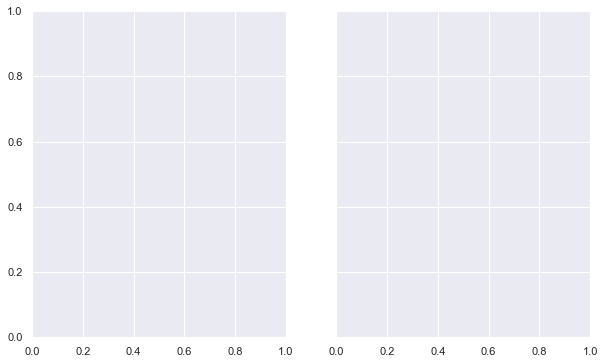

In [45]:
plot_conf_matrix(cc_isof, x_train, y_train, x_test, y_test, class_names)